# Fit logistic regression model

- based on different imputation methods
- baseline: reference
- model: any other selected imputation method

In [1]:
import logging
from pathlib import Path
from typing import List

import matplotlib.pyplot as plt
import njab.sklearn
import pandas as pd
import sklearn
from njab.plotting.metrics import plot_split_auc, plot_split_prc
from njab.sklearn.types import Splits

import pimmslearn
import pimmslearn.analyzers
import pimmslearn.io.datasplits

plt.rcParams['figure.figsize'] = (2.5, 2.5)
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.markersize'] = 2
fontsize = 5
figsize = (2.5, 2.5)
pimmslearn.plotting.make_large_descriptors(fontsize)


logger = pimmslearn.logging.setup_nb_logger()
logging.getLogger('fontTools').setLevel(logging.ERROR)


def parse_roc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _roc = (pd.DataFrame(_r.test.roc,
                             index='fpr tpr cutoffs'.split()
                             )).loc[['fpr', 'tpr']]
        _roc = _roc.T
        _roc.columns = pd.MultiIndex.from_product([[_r.name], _roc.columns])
        ret.append(_roc)
    ret = pd.concat(ret, axis=1)
    return ret


def parse_prc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _prc = pd.DataFrame(_r.test.prc,
                            index='precision recall cutoffs'.split()
                            ).loc[['precision', 'recall']]
        _prc = _prc.T.rename(columns={'recall': 'tpr'})
        _prc.columns = pd.MultiIndex.from_product([[_r.name], _prc.columns])
        ret.append(_prc)
    ret = pd.concat(ret, axis=1)
    return ret


# catch passed parameters
args = None
args = dict(globals()).keys()

## Parameters
Default and set parameters for the notebook.

In [2]:
folder_data: str = ''  # specify data directory if needed
fn_clinical_data = "data/ALD_study/processed/ald_metadata_cli.csv"
folder_experiment = "runs/appl_ald_data/plasma/proteinGroups"
model_key = 'VAE'
target = 'kleiner'
sample_id_col = 'Sample ID'
cutoff_target: int = 2  # => for binarization target >= cutoff_target
file_format = "csv"
out_folder = 'diff_analysis'
fn_qc_samples = ''  # 'data/ALD_study/processed/qc_plasma_proteinGroups.pkl'

baseline = 'RSN'  # default is RSN, as this was used in the original ALD Niu. et. al 2022
template_pred = 'pred_real_na_{}.csv'  # fixed, do not change

In [3]:
# Parameters
cutoff_target = 0.5
folder_experiment = "runs/alzheimer_study"
target = "AD"
baseline = "PI"
model_key = "RF"
out_folder = "diff_analysis"
fn_clinical_data = "runs/alzheimer_study/data/clinical_data.csv"


In [4]:
params = pimmslearn.nb.get_params(args, globals=globals())
args = pimmslearn.nb.Config()
args.folder_experiment = Path(params["folder_experiment"])
args = pimmslearn.nb.add_default_paths(args,
                                 out_root=(args.folder_experiment
                                           / params["out_folder"]
                                           / params["target"]
                                           / f"{params['baseline']}_vs_{params['model_key']}"))
args.update_from_dict(params)
files_out = dict()
args

root - INFO     Removed from global namespace: folder_data


root - INFO     Removed from global namespace: fn_clinical_data


root - INFO     Removed from global namespace: folder_experiment


root - INFO     Removed from global namespace: model_key


root - INFO     Removed from global namespace: target


root - INFO     Removed from global namespace: sample_id_col


root - INFO     Removed from global namespace: cutoff_target


root - INFO     Removed from global namespace: file_format


root - INFO     Removed from global namespace: out_folder


root - INFO     Removed from global namespace: fn_qc_samples


root - INFO     Removed from global namespace: baseline


root - INFO     Removed from global namespace: template_pred


root - INFO     Already set attribute: folder_experiment has value runs/alzheimer_study


root - INFO     Already set attribute: out_folder has value diff_analysis


{'baseline': 'PI',
 'cutoff_target': 0.5,
 'data': PosixPath('runs/alzheimer_study/data'),
 'file_format': 'csv',
 'fn_clinical_data': 'runs/alzheimer_study/data/clinical_data.csv',
 'fn_qc_samples': '',
 'folder_data': '',
 'folder_experiment': PosixPath('runs/alzheimer_study'),
 'model_key': 'RF',
 'out_figures': PosixPath('runs/alzheimer_study/figures'),
 'out_folder': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_RF'),
 'out_metrics': PosixPath('runs/alzheimer_study'),
 'out_models': PosixPath('runs/alzheimer_study'),
 'out_preds': PosixPath('runs/alzheimer_study/preds'),
 'sample_id_col': 'Sample ID',
 'target': 'AD',
 'template_pred': 'pred_real_na_{}.csv'}

## Load data

### Load target

In [5]:
target = pd.read_csv(args.fn_clinical_data,
                     index_col=0,
                     usecols=[args.sample_id_col, args.target])
target = target.dropna()
target

,AD
Sample ID,
Sample_000,0
Sample_001,1
Sample_002,1
Sample_003,1
Sample_004,1
...,...
Sample_205,1
Sample_206,0
Sample_207,0


### MS proteomics or specified omics data
Aggregated from data splits of the imputation workflow run before.

In [6]:
data = pimmslearn.io.datasplits.DataSplits.from_folder(
    args.data, file_format=args.file_format)
data = pd.concat([data.train_X, data.val_y, data.test_y])
data.sample(5)

pimmslearn.io.datasplits - INFO     Loaded 'train_X' from file: runs/alzheimer_study/data/train_X.csv


pimmslearn.io.datasplits - INFO     Loaded 'val_y' from file: runs/alzheimer_study/data/val_y.csv


pimmslearn.io.datasplits - INFO     Loaded 'test_y' from file: runs/alzheimer_study/data/test_y.csv


Sample ID   protein groups      
Sample_113  O14791;O14791-2        16.123
Sample_032  A0A087WXM8;P50895      15.687
Sample_101  Q9HBW1                 16.990
Sample_020  Q9BTY2                 16.498
Sample_098  F5GWQ8;J3QKW8;Q15846   14.877
Name: intensity, dtype: float64

Get overlap between independent features and target

### Select by ALD criteria
Use parameters as specified in [ALD study](https://github.com/RasmussenLab/pimms/tree/main/project/data/ALD_study).

In [7]:
DATA_COMPLETENESS = 0.6
MIN_N_PROTEIN_GROUPS: int = 200
FRAC_PROTEIN_GROUPS: int = 0.622
CV_QC_SAMPLE: float = 0.4

ald_study, cutoffs = pimmslearn.analyzers.diff_analysis.select_raw_data(data.unstack(
), data_completeness=DATA_COMPLETENESS, frac_protein_groups=FRAC_PROTEIN_GROUPS)

if args.fn_qc_samples:
    qc_samples = pd.read_pickle(args.fn_qc_samples)
    qc_samples = qc_samples[ald_study.columns]
    qc_cv_feat = qc_samples.std() / qc_samples.mean()
    qc_cv_feat = qc_cv_feat.rename(qc_samples.columns.name)
    fig, ax = plt.subplots(figsize=(4, 7))
    ax = qc_cv_feat.plot.box(ax=ax)
    ax.set_ylabel('Coefficient of Variation')
    print((qc_cv_feat < CV_QC_SAMPLE).value_counts())
    ald_study = ald_study[pimmslearn.analyzers.diff_analysis.select_feat(qc_samples)]

column_name_first_prot_to_pg = {
    pg.split(';')[0]: pg for pg in data.unstack().columns}

ald_study = ald_study.rename(columns=column_name_first_prot_to_pg)
ald_study

root - INFO     Initally: N samples: 210, M feat: 1421


root - INFO     Dropped features quantified in less than 126 samples.


root - INFO     After feat selection: N samples: 210, M feat: 1213


root - INFO     Min No. of Protein-Groups in single sample: 754


root - INFO     Finally: N samples: 210, M feat: 1213


protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6J9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,NaN,...,16.012,15.178,NaN,15.050,16.842,19.863,NaN,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,NaN,19.067,16.188,...,15.528,15.576,NaN,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,NaN,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,13.438,...,15.495,14.590,14.682,15.140,17.356,19.429,NaN,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,14.495,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,NaN,16.413,19.102,16.064,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,15.288,...,15.422,16.106,NaN,15.345,17.084,18.708,14.249,19.433,NaN,NaN
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,17.580,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


Number of complete cases which can be used:

In [8]:
mask_has_target = data.index.levels[0].intersection(target.index)
assert not mask_has_target.empty, f"No data for target: {data.index.levels[0]} and {target.index}"
print(
    f"Samples available both in proteomics data and for target: {len(mask_has_target)}")
target, data, ald_study = target.loc[mask_has_target], data.loc[mask_has_target], ald_study.loc[mask_has_target]

Samples available both in proteomics data and for target: 210


### Load imputations from specified model

In [9]:
fname = args.out_preds / args.template_pred.format(args.model_key)
print(f"missing values pred. by {args.model_key}: {fname}")
load_single_csv_pred_file = pimmslearn.analyzers.compare_predictions.load_single_csv_pred_file
pred_real_na = load_single_csv_pred_file(fname).loc[mask_has_target]
pred_real_na.sample(3)

missing values pred. by RF: runs/alzheimer_study/preds/pred_real_na_RF.csv


Sample ID   protein groups                 
Sample_058  A0A0C4DGV4;E9PLX3;O43504;R4GMU8   14.300
Sample_182  Q9NZU1                            13.271
Sample_138  J3KQ18;P30046                     14.647
Name: intensity, dtype: float64

### Load imputations from baseline model

In [10]:
fname = args.out_preds / args.template_pred.format(args.baseline)
pred_real_na_baseline = load_single_csv_pred_file(fname)  # .loc[mask_has_target]
pred_real_na_baseline

Sample ID   protein groups          
Sample_000  A0A075B6J9                 12.576
            A0A075B6Q5                 12.897
            A0A075B6R2                 13.015
            A0A075B6S5                 13.516
            A0A087WSY4                 13.417
                                        ...  
Sample_209  Q9P1W8;Q9P1W8-2;Q9P1W8-4   13.303
            Q9UI40;Q9UI40-2            12.773
            Q9UIW2                     11.710
            Q9UMX0;Q9UMX0-2;Q9UMX0-4   12.573
            Q9UP79                     12.196
Name: intensity, Length: 46401, dtype: float64

## Modeling setup
General approach:
  - use one train, test split of the data
  - select best 10 features from training data `X_train`, `y_train` before binarization of target
  - dichotomize (binarize) data into to groups (zero and 1)
  - evaluate model on the test data `X_test`, `y_test`

Repeat general approach for
 1. all original ald data: all features justed in original ALD study
 2. all model data: all features available my using the self supervised deep learning model
 3. newly available feat only: the subset of features available from the
    self supervised deep learning model which were newly retained using the
    new approach

All data:

In [11]:
X = pd.concat([data, pred_real_na]).unstack()
X

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H7,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,17.301,20.246,16.764,17.584,16.988,20.054,...,16.012,15.178,13.956,15.050,16.842,19.863,15.597,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,13.796,19.941,18.786,17.144,16.447,19.067,...,15.528,15.576,14.131,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,18.175,19.251,16.832,15.671,17.012,18.569,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,15.963,19.628,17.852,18.877,14.182,18.985,...,15.495,14.590,14.682,15.140,17.356,19.429,15.576,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,15.473,20.450,18.682,17.081,14.140,19.686,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,15.537,17.705,17.039,16.411,16.413,19.102,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,15.884,18.154,18.152,16.503,16.860,18.538,...,15.422,16.106,14.363,15.345,17.084,18.708,14.249,19.433,11.724,11.772
Sample_207,15.739,16.877,15.469,16.898,15.603,18.636,17.950,16.321,16.401,18.849,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


### Subset of data by ALD criteria

In [12]:
# could be just observed, drop columns with missing values
ald_study = pd.concat(
    [ald_study.stack(),
     pred_real_na_baseline.loc[
        # only select columns in selected in ald_study
        pd.IndexSlice[:, pred_real_na.index.levels[-1].intersection(ald_study.columns)]
    ]
    ]
).unstack()
ald_study

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6K4,...,O14793,O95479;R4GMU1,P01282;P01282-2,P10619;P10619-2;X6R5C5;X6R8A1,P21810,Q14956;Q14956-2,Q6ZMP0;Q6ZMP0-2,Q9HBW1,Q9NY15,P17050
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,16.148,...,12.713,11.766,11.115,13.513,13.025,12.894,12.024,12.528,14.653,12.723
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,12.037,19.067,16.127,...,13.069,12.219,14.253,13.523,13.252,12.458,13.385,13.374,12.990,13.450
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,15.387,...,12.976,13.031,12.682,12.933,11.861,14.017,12.818,13.224,13.031,10.661
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,16.565,...,13.525,11.105,12.354,13.312,11.640,11.493,13.235,13.868,12.094,12.408
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,16.418,...,13.071,12.413,12.593,12.126,12.699,12.679,12.182,12.244,14.092,14.426
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,12.675,16.413,19.102,15.350,...,14.269,14.064,16.826,18.182,15.225,15.044,14.192,16.605,14.995,14.257
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,16.582,...,14.273,17.700,16.802,20.202,15.280,15.086,13.978,18.086,15.557,14.171
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,15.768,...,14.473,16.882,16.917,20.105,15.690,15.135,13.138,17.066,15.706,15.690


Features which would not have been included using ALD criteria:

In [13]:
new_features = X.columns.difference(ald_study.columns)
new_features

Index(['A0A075B6H7', 'A0A075B6Q5', 'A0A075B7B8', 'A0A087WSY4',
       'A0A087WTT8;A0A0A0MQX5;O94779;O94779-2', 'A0A087WXB8;Q9Y274',
       'A0A087WXE9;E9PQ70;Q6UXH9;Q6UXH9-2;Q6UXH9-3',
       'A0A087X1Z2;C9JTV4;H0Y4Y4;Q8WYH2;Q96C19;Q9BUP0;Q9BUP0-2',
       'A0A0A0MQS9;A0A0A0MTC7;Q16363;Q16363-2', 'A0A0A0MSN4;P12821;P12821-2',
       ...
       'Q9NZ94;Q9NZ94-2;Q9NZ94-3', 'Q9NZU1', 'Q9P1W8;Q9P1W8-2;Q9P1W8-4',
       'Q9UHI8', 'Q9UI40;Q9UI40-2',
       'Q9UIB8;Q9UIB8-2;Q9UIB8-3;Q9UIB8-4;Q9UIB8-5;Q9UIB8-6',
       'Q9UKZ4;Q9UKZ4-2', 'Q9UMX0;Q9UMX0-2;Q9UMX0-4', 'Q9Y281;Q9Y281-3',
       'Q9Y490'],
      dtype='object', name='protein groups', length=208)

Binarize targets, but also keep groups for stratification

In [14]:
target_to_group = target.copy()
target = target >= args.cutoff_target
pd.crosstab(target.squeeze(), target_to_group.squeeze())

AD,0,1
AD,,
False,122,0
True,0,88


## Determine best number of parameters by cross validation procedure

using subset of data by ALD criteria:

In [15]:
cv_feat_ald = njab.sklearn.find_n_best_features(X=ald_study, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_ald = (cv_feat_ald
               .drop('test_case', axis=1)
               .groupby('n_features')
               .agg(['mean', 'std']))
cv_feat_ald

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 346.64it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  7.71it/s]

100%|██████████| 2/2 [00:00<00:00,  7.65it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  9.06it/s]

100%|██████████| 3/3 [00:00<00:00,  5.76it/s]

100%|██████████| 3/3 [00:00<00:00,  6.19it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  6.86it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  4.64it/s]

100%|██████████| 4/4 [00:00<00:00,  4.03it/s]

100%|██████████| 4/4 [00:00<00:00,  4.38it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  6.28it/s]

 60%|██████    | 3/5 [00:00<00:00,  5.10it/s]

 80%|████████  | 4/5 [00:00<00:00,  4.45it/s]

100%|██████████| 5/5 [00:01<00:00,  4.15it/s]

100%|██████████| 5/5 [00:01<00:00,  4.50it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00,  7.22it/s]

 50%|█████     | 3/6 [00:00<00:00,  4.84it/s]

 67%|██████▋   | 4/6 [00:00<00:00,  4.38it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  4.00it/s]

100%|██████████| 6/6 [00:01<00:00,  3.79it/s]

100%|██████████| 6/6 [00:01<00:00,  4.20it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:00,  7.31it/s]

 43%|████▎     | 3/7 [00:00<00:00,  5.24it/s]

 57%|█████▋    | 4/7 [00:00<00:00,  4.63it/s]

 71%|███████▏  | 5/7 [00:01<00:00,  4.20it/s]

 86%|████████▌ | 6/7 [00:01<00:00,  3.97it/s]

100%|██████████| 7/7 [00:01<00:00,  3.69it/s]

100%|██████████| 7/7 [00:01<00:00,  4.19it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:00,  7.07it/s]

 38%|███▊      | 3/8 [00:00<00:00,  5.28it/s]

 50%|█████     | 4/8 [00:00<00:00,  4.64it/s]

 62%|██████▎   | 5/8 [00:01<00:00,  4.15it/s]

 75%|███████▌  | 6/8 [00:01<00:00,  4.12it/s]

 88%|████████▊ | 7/8 [00:01<00:00,  3.77it/s]

100%|██████████| 8/8 [00:01<00:00,  3.73it/s]

100%|██████████| 8/8 [00:01<00:00,  4.16it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:00,  7.84it/s]

 33%|███▎      | 3/9 [00:00<00:01,  5.44it/s]

 44%|████▍     | 4/9 [00:00<00:01,  4.39it/s]

 56%|█████▌    | 5/9 [00:01<00:01,  3.84it/s]

 67%|██████▋   | 6/9 [00:01<00:00,  3.82it/s]

 78%|███████▊  | 7/9 [00:01<00:00,  3.84it/s]

 89%|████████▉ | 8/9 [00:01<00:00,  3.76it/s]

100%|██████████| 9/9 [00:02<00:00,  3.65it/s]

100%|██████████| 9/9 [00:02<00:00,  4.03it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:01,  7.26it/s]

 30%|███       | 3/10 [00:00<00:01,  4.96it/s]

 40%|████      | 4/10 [00:00<00:01,  4.54it/s]

 50%|█████     | 5/10 [00:01<00:01,  4.19it/s]

 60%|██████    | 6/10 [00:01<00:00,  4.02it/s]

 70%|███████   | 7/10 [00:01<00:00,  3.93it/s]

 80%|████████  | 8/10 [00:01<00:00,  3.91it/s]

 90%|█████████ | 9/10 [00:02<00:00,  3.95it/s]

100%|██████████| 10/10 [00:02<00:00,  3.78it/s]

100%|██████████| 10/10 [00:02<00:00,  4.12it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:01,  7.16it/s]

 27%|██▋       | 3/11 [00:00<00:01,  5.03it/s]

 36%|███▋      | 4/11 [00:00<00:01,  4.60it/s]

 45%|████▌     | 5/11 [00:01<00:01,  4.62it/s]

 55%|█████▍    | 6/11 [00:01<00:01,  4.60it/s]

 64%|██████▎   | 7/11 [00:01<00:00,  4.43it/s]

 73%|███████▎  | 8/11 [00:01<00:00,  3.94it/s]

 82%|████████▏ | 9/11 [00:02<00:00,  3.87it/s]

 91%|█████████ | 10/11 [00:02<00:00,  3.82it/s]

100%|██████████| 11/11 [00:02<00:00,  3.84it/s]

100%|██████████| 11/11 [00:02<00:00,  4.23it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:01,  8.51it/s]

 25%|██▌       | 3/12 [00:00<00:01,  5.76it/s]

 33%|███▎      | 4/12 [00:00<00:01,  4.77it/s]

 42%|████▏     | 5/12 [00:01<00:01,  4.32it/s]

 50%|█████     | 6/12 [00:01<00:01,  4.02it/s]

 58%|█████▊    | 7/12 [00:01<00:01,  4.06it/s]

 67%|██████▋   | 8/12 [00:01<00:00,  4.09it/s]

 75%|███████▌  | 9/12 [00:02<00:00,  4.21it/s]

 83%|████████▎ | 10/12 [00:02<00:00,  4.38it/s]

 92%|█████████▏| 11/12 [00:02<00:00,  4.29it/s]

100%|██████████| 12/12 [00:02<00:00,  4.19it/s]

100%|██████████| 12/12 [00:02<00:00,  4.41it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:01,  7.32it/s]

 23%|██▎       | 3/13 [00:00<00:01,  5.37it/s]

 31%|███       | 4/13 [00:00<00:01,  4.71it/s]

 38%|███▊      | 5/13 [00:01<00:02,  3.94it/s]

 46%|████▌     | 6/13 [00:01<00:01,  3.60it/s]

 54%|█████▍    | 7/13 [00:01<00:02,  2.99it/s]

 62%|██████▏   | 8/13 [00:02<00:01,  3.02it/s]

 69%|██████▉   | 9/13 [00:02<00:01,  3.07it/s]

 77%|███████▋  | 10/13 [00:02<00:01,  2.78it/s]

 85%|████████▍ | 11/13 [00:03<00:00,  2.92it/s]

 92%|█████████▏| 12/13 [00:03<00:00,  2.91it/s]

100%|██████████| 13/13 [00:03<00:00,  2.86it/s]

100%|██████████| 13/13 [00:03<00:00,  3.26it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:02,  5.25it/s]

 21%|██▏       | 3/14 [00:00<00:03,  3.45it/s]

 29%|██▊       | 4/14 [00:01<00:03,  2.93it/s]

 36%|███▌      | 5/14 [00:01<00:03,  2.67it/s]

 43%|████▎     | 6/14 [00:02<00:03,  2.55it/s]

 50%|█████     | 7/14 [00:02<00:02,  2.79it/s]

 57%|█████▋    | 8/14 [00:02<00:02,  2.90it/s]

 64%|██████▍   | 9/14 [00:02<00:01,  3.10it/s]

 71%|███████▏  | 10/14 [00:03<00:01,  3.30it/s]

 79%|███████▊  | 11/14 [00:03<00:00,  3.36it/s]

 86%|████████▌ | 12/14 [00:03<00:00,  3.46it/s]

 93%|█████████▎| 13/14 [00:04<00:00,  3.62it/s]

100%|██████████| 14/14 [00:04<00:00,  3.60it/s]

100%|██████████| 14/14 [00:04<00:00,  3.24it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:02,  5.93it/s]

 20%|██        | 3/15 [00:00<00:02,  4.09it/s]

 27%|██▋       | 4/15 [00:00<00:02,  3.89it/s]

 33%|███▎      | 5/15 [00:01<00:02,  3.86it/s]

 40%|████      | 6/15 [00:01<00:02,  3.77it/s]

 47%|████▋     | 7/15 [00:01<00:02,  3.86it/s]

 53%|█████▎    | 8/15 [00:02<00:01,  3.59it/s]

 60%|██████    | 9/15 [00:02<00:02,  2.99it/s]

 67%|██████▋   | 10/15 [00:02<00:01,  2.74it/s]

 73%|███████▎  | 11/15 [00:03<00:01,  2.71it/s]

 80%|████████  | 12/15 [00:03<00:01,  2.63it/s]

 87%|████████▋ | 13/15 [00:04<00:00,  2.89it/s]

 93%|█████████▎| 14/15 [00:04<00:00,  3.00it/s]

100%|██████████| 15/15 [00:04<00:00,  3.07it/s]

100%|██████████| 15/15 [00:04<00:00,  3.24it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.003 0.001      0.032 0.005          0.858 0.236       0.154   
2             0.003 0.000      0.037 0.008          0.675 0.112       0.545   
3             0.003 0.000      0.035 0.000          0.697 0.105       0.628   
4             0.003 0.000      0.035 0.001          0.721 0.098       0.660   
5             0.003 0.000      0.035 0.004          0.702 0.098       0.677   
6             0.003 0.000      0.035 0.003          0.803 0.079       0.797   
7             0.003 0.000      0.035 0.000          0.803 0.079       0.799   
8             0.003 0.000      0.035 0.000          0.801 0.082       0.794   
9             0.003 0.000      0.036 0.002          0.798 0.085       0.781   
10            0.003 0.000      0.030 0.007          0.798 0.086       0.786   
11            0.003 0.000      0.034 0.010          0.814 0.088       0.812   
12            0.004 0.002      0.034 0.005          0.814 0.088       0.820   
13            0.004 0.003      0.047 0.022          0.813 0.088       0.820   
14            0.005 0.003      0.043 0.014          0.819 0.085       0.804   
15            0.004 0.002      0.038 0.012          0.814 0.089       0.798   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.086   0.253 0.122                  0.569 0.041        0.855   
2          0.107   0.595 0.085                  0.672 0.062        0.726   
3          0.131   0.650 0.089                  0.709 0.068        0.791   
4          0.111   0.682 0.077                  0.733 0.061        0.819   
5          0.113   0.684 0.085                  0.731 0.070        0.817   
6          0.110   0.795 0.071                  0.826 0.058        0.897   
7          0.108   0.796 0.071                  0.827 0.059        0.895   
8          0.103   0.793 0.070                  0.824 0.058        0.895   
9          0.105   0.785 0.073                  0.817 0.060        0.893   
10         0.107   0.787 0.076                  0.819 0.063        0.896   
11         0.101   0.809 0.072                  0.836 0.062        0.906   
12         0.092   0.813 0.071                  0.840 0.061        0.905   
13         0.094   0.813 0.072                  0.840 0.062        0.904   
14         0.101   0.808 0.076                  0.836 0.063        0.911   
15         0.101   0.802 0.077                  0.831 0.065        0.910   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.062                  0.825 0.088        210.000 0.000  
2          0.079                  0.683 0.100        210.000 0.000  
3          0.072                  0.719 0.095        210.000 0.000  
4          0.063                  0.783 0.088        210.000 0.000  
5          0.059                  0.778 0.088        210.000 0.000  
6          0.046                  0.869 0.060        210.000 0.000  
7          0.047                  0.867 0.061        210.000 0.000  
8          0.049                  0.866 0.064        210.000 0.000  
9          0.050                  0.864 0.063        210.000 0.000  
10         0.050                  0.873 0.059        210.000 0.000  
11         0.050                  0.889 0.056        210.000 0.000  
12         0.052                  0.891 0.054        210.000 0.000  
13         0.052                  0.891 0.054        210.000 0.000  
14         0.049                  0.900 0.050        210.000 0.000  
15         0.050                  0.898 0.051 

Using all data:

In [16]:
cv_feat_all = njab.sklearn.find_n_best_features(X=X, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_all = cv_feat_all.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_all

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 517.69it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  4.01it/s]

100%|██████████| 2/2 [00:00<00:00,  4.00it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  4.24it/s]

100%|██████████| 3/3 [00:00<00:00,  2.93it/s]

100%|██████████| 3/3 [00:00<00:00,  3.12it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  6.56it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  4.71it/s]

100%|██████████| 4/4 [00:00<00:00,  3.75it/s]

100%|██████████| 4/4 [00:00<00:00,  4.17it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  5.04it/s]

 60%|██████    | 3/5 [00:00<00:00,  4.14it/s]

 80%|████████  | 4/5 [00:00<00:00,  3.88it/s]

100%|██████████| 5/5 [00:01<00:00,  3.71it/s]

100%|██████████| 5/5 [00:01<00:00,  3.92it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00,  4.87it/s]

 50%|█████     | 3/6 [00:00<00:00,  3.59it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  3.12it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  3.14it/s]

100%|██████████| 6/6 [00:01<00:00,  3.24it/s]

100%|██████████| 6/6 [00:01<00:00,  3.35it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:00,  5.46it/s]

 43%|████▎     | 3/7 [00:00<00:00,  4.66it/s]

 57%|█████▋    | 4/7 [00:00<00:00,  4.15it/s]

 71%|███████▏  | 5/7 [00:01<00:00,  3.80it/s]

 86%|████████▌ | 6/7 [00:01<00:00,  3.53it/s]

100%|██████████| 7/7 [00:01<00:00,  3.29it/s]

100%|██████████| 7/7 [00:01<00:00,  3.69it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:01,  4.41it/s]

 38%|███▊      | 3/8 [00:00<00:01,  3.56it/s]

 50%|█████     | 4/8 [00:01<00:01,  3.04it/s]

 62%|██████▎   | 5/8 [00:01<00:00,  3.12it/s]

 75%|███████▌  | 6/8 [00:01<00:00,  3.41it/s]

 88%|████████▊ | 7/8 [00:02<00:00,  3.43it/s]

100%|██████████| 8/8 [00:02<00:00,  3.20it/s]

100%|██████████| 8/8 [00:02<00:00,  3.32it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:01,  4.76it/s]

 33%|███▎      | 3/9 [00:00<00:01,  3.18it/s]

 44%|████▍     | 4/9 [00:01<00:01,  2.56it/s]

 56%|█████▌    | 5/9 [00:01<00:01,  2.55it/s]

 67%|██████▋   | 6/9 [00:02<00:01,  2.74it/s]

 78%|███████▊  | 7/9 [00:02<00:00,  2.86it/s]

 89%|████████▉ | 8/9 [00:02<00:00,  2.99it/s]

100%|██████████| 9/9 [00:03<00:00,  3.11it/s]

100%|██████████| 9/9 [00:03<00:00,  2.98it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:01,  4.01it/s]

 30%|███       | 3/10 [00:01<00:02,  2.67it/s]

 40%|████      | 4/10 [00:01<00:02,  2.87it/s]

 50%|█████     | 5/10 [00:01<00:01,  2.88it/s]

 60%|██████    | 6/10 [00:02<00:01,  2.86it/s]

 70%|███████   | 7/10 [00:02<00:01,  2.93it/s]

 80%|████████  | 8/10 [00:02<00:00,  2.93it/s]

 90%|█████████ | 9/10 [00:03<00:00,  2.99it/s]

100%|██████████| 10/10 [00:03<00:00,  3.14it/s]

100%|██████████| 10/10 [00:03<00:00,  3.01it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:01,  4.68it/s]

 27%|██▋       | 3/11 [00:00<00:02,  3.08it/s]

 36%|███▋      | 4/11 [00:01<00:02,  2.59it/s]

 45%|████▌     | 5/11 [00:01<00:02,  2.65it/s]

 55%|█████▍    | 6/11 [00:02<00:01,  2.59it/s]

 64%|██████▎   | 7/11 [00:02<00:01,  2.79it/s]

 73%|███████▎  | 8/11 [00:02<00:01,  2.89it/s]

 82%|████████▏ | 9/11 [00:03<00:00,  2.93it/s]

 91%|█████████ | 10/11 [00:03<00:00,  2.98it/s]

100%|██████████| 11/11 [00:03<00:00,  3.10it/s]

100%|██████████| 11/11 [00:03<00:00,  2.95it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:01,  5.34it/s]

 25%|██▌       | 3/12 [00:00<00:02,  3.68it/s]

 33%|███▎      | 4/12 [00:01<00:02,  3.06it/s]

 42%|████▏     | 5/12 [00:01<00:02,  2.69it/s]

 50%|█████     | 6/12 [00:02<00:02,  2.65it/s]

 58%|█████▊    | 7/12 [00:02<00:01,  2.66it/s]

 67%|██████▋   | 8/12 [00:02<00:01,  2.68it/s]

 75%|███████▌  | 9/12 [00:03<00:01,  2.63it/s]

 83%|████████▎ | 10/12 [00:03<00:00,  2.80it/s]

 92%|█████████▏| 11/12 [00:03<00:00,  3.08it/s]

100%|██████████| 12/12 [00:04<00:00,  3.08it/s]

100%|██████████| 12/12 [00:04<00:00,  2.97it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:01,  6.78it/s]

 23%|██▎       | 3/13 [00:00<00:02,  4.19it/s]

 31%|███       | 4/13 [00:01<00:02,  3.28it/s]

 38%|███▊      | 5/13 [00:01<00:02,  2.92it/s]

 46%|████▌     | 6/13 [00:01<00:02,  3.00it/s]

 54%|█████▍    | 7/13 [00:02<00:02,  2.83it/s]

 62%|██████▏   | 8/13 [00:02<00:01,  2.77it/s]

 69%|██████▉   | 9/13 [00:02<00:01,  2.72it/s]

 77%|███████▋  | 10/13 [00:03<00:01,  2.64it/s]

 85%|████████▍ | 11/13 [00:03<00:00,  2.38it/s]

 92%|█████████▏| 12/13 [00:04<00:00,  2.37it/s]

100%|██████████| 13/13 [00:04<00:00,  2.37it/s]

100%|██████████| 13/13 [00:04<00:00,  2.75it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:02,  5.22it/s]

 21%|██▏       | 3/14 [00:00<00:02,  3.79it/s]

 29%|██▊       | 4/14 [00:01<00:03,  2.98it/s]

 36%|███▌      | 5/14 [00:01<00:03,  2.71it/s]

 43%|████▎     | 6/14 [00:02<00:03,  2.63it/s]

 50%|█████     | 7/14 [00:02<00:02,  2.63it/s]

 57%|█████▋    | 8/14 [00:02<00:02,  2.58it/s]

 64%|██████▍   | 9/14 [00:03<00:01,  2.69it/s]

 71%|███████▏  | 10/14 [00:03<00:01,  2.74it/s]

 79%|███████▊  | 11/14 [00:03<00:01,  2.81it/s]

 86%|████████▌ | 12/14 [00:04<00:00,  2.91it/s]

 93%|█████████▎| 13/14 [00:04<00:00,  2.96it/s]

100%|██████████| 14/14 [00:04<00:00,  2.75it/s]

100%|██████████| 14/14 [00:04<00:00,  2.85it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:01,  7.95it/s]

 20%|██        | 3/15 [00:00<00:02,  5.20it/s]

 27%|██▋       | 4/15 [00:00<00:02,  3.95it/s]

 33%|███▎      | 5/15 [00:01<00:03,  3.03it/s]

 40%|████      | 6/15 [00:01<00:03,  2.66it/s]

 47%|████▋     | 7/15 [00:02<00:03,  2.52it/s]

 53%|█████▎    | 8/15 [00:02<00:03,  2.31it/s]

 60%|██████    | 9/15 [00:03<00:02,  2.18it/s]

 67%|██████▋   | 10/15 [00:03<00:02,  2.27it/s]

 73%|███████▎  | 11/15 [00:04<00:01,  2.41it/s]

 80%|████████  | 12/15 [00:04<00:01,  2.45it/s]

 87%|████████▋ | 13/15 [00:04<00:00,  2.55it/s]

 93%|█████████▎| 14/15 [00:05<00:00,  2.71it/s]

100%|██████████| 15/15 [00:05<00:00,  2.78it/s]

100%|██████████| 15/15 [00:05<00:00,  2.75it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.004 0.003      0.047 0.025          0.000 0.000       0.000   
2             0.004 0.002      0.043 0.018          0.771 0.114       0.581   
3             0.005 0.004      0.046 0.018          0.717 0.125       0.595   
4             0.004 0.003      0.044 0.014          0.704 0.126       0.579   
5             0.004 0.003      0.046 0.017          0.689 0.103       0.586   
6             0.005 0.005      0.049 0.018          0.699 0.108       0.607   
7             0.005 0.004      0.043 0.015          0.688 0.114       0.611   
8             0.004 0.002      0.041 0.013          0.797 0.099       0.722   
9             0.004 0.003      0.045 0.016          0.790 0.101       0.701   
10            0.005 0.003      0.046 0.016          0.797 0.103       0.702   
11            0.005 0.004      0.050 0.017          0.836 0.094       0.750   
12            0.004 0.003      0.040 0.013          0.843 0.093       0.775   
13            0.004 0.001      0.041 0.014          0.835 0.092       0.776   
14            0.005 0.005      0.055 0.023          0.845 0.090       0.790   
15            0.004 0.003      0.043 0.013          0.861 0.081       0.789   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.000   0.000 0.000                  0.498 0.006        0.845   
2          0.139   0.651 0.105                  0.724 0.070        0.771   
3          0.130   0.640 0.103                  0.706 0.077        0.774   
4          0.135   0.625 0.107                  0.696 0.078        0.766   
5          0.133   0.625 0.100                  0.694 0.073        0.769   
6          0.122   0.640 0.084                  0.703 0.064        0.779   
7          0.127   0.638 0.093                  0.700 0.071        0.777   
8          0.117   0.749 0.074                  0.790 0.058        0.885   
9          0.115   0.736 0.084                  0.780 0.066        0.884   
10         0.118   0.739 0.084                  0.783 0.065        0.883   
11         0.099   0.784 0.067                  0.818 0.055        0.904   
12         0.117   0.800 0.074                  0.832 0.060        0.914   
13         0.111   0.798 0.073                  0.829 0.059        0.915   
14         0.104   0.811 0.073                  0.840 0.060        0.917   
15         0.104   0.818 0.068                  0.846 0.056        0.918   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.064                  0.816 0.088        210.000 0.000  
2          0.077                  0.723 0.094        210.000 0.000  
3          0.073                  0.730 0.092        210.000 0.000  
4          0.080                  0.718 0.098        210.000 0.000  
5          0.080                  0.704 0.101        210.000 0.000  
6          0.072                  0.736 0.093        210.000 0.000  
7          0.073                  0.728 0.095        210.000 0.000  
8          0.052                  0.860 0.064        210.000 0.000  
9          0.052                  0.861 0.062        210.000 0.000  
10         0.053                  0.860 0.064        210.000 0.000  
11         0.049                  0.882 0.061        210.000 0.000  
12         0.045                  0.890 0.057        210.000 0.000  
13         0.045                  0.892 0.058        210.000 0.000  
14         0.046                  0.892 0.058        210.000 0.000  
15         0.045                  0.895 0.056 

Using only new features:

In [17]:
cv_feat_new = njab.sklearn.find_n_best_features(X=X.loc[:, new_features],
                                                y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_new = cv_feat_new.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_new

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 1146.61it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00, 36.14it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:00<00:00, 20.06it/s]

100%|██████████| 3/3 [00:00<00:00, 19.96it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 75%|███████▌  | 3/4 [00:00<00:00, 21.95it/s]

100%|██████████| 4/4 [00:00<00:00, 18.18it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 60%|██████    | 3/5 [00:00<00:00, 22.44it/s]

100%|██████████| 5/5 [00:00<00:00, 19.74it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 50%|█████     | 3/6 [00:00<00:00, 21.75it/s]

100%|██████████| 6/6 [00:00<00:00, 18.22it/s]

100%|██████████| 6/6 [00:00<00:00, 18.56it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 43%|████▎     | 3/7 [00:00<00:00, 18.07it/s]

 71%|███████▏  | 5/7 [00:00<00:00, 15.33it/s]

100%|██████████| 7/7 [00:00<00:00, 15.05it/s]

100%|██████████| 7/7 [00:00<00:00, 15.01it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 38%|███▊      | 3/8 [00:00<00:00, 22.89it/s]

 75%|███████▌  | 6/8 [00:00<00:00, 18.45it/s]

100%|██████████| 8/8 [00:00<00:00, 16.53it/s]

100%|██████████| 8/8 [00:00<00:00, 17.34it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 33%|███▎      | 3/9 [00:00<00:00, 20.36it/s]

 67%|██████▋   | 6/9 [00:00<00:00, 16.11it/s]

 89%|████████▉ | 8/9 [00:00<00:00, 14.83it/s]

100%|██████████| 9/9 [00:00<00:00, 15.31it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 30%|███       | 3/10 [00:00<00:00, 19.43it/s]

 50%|█████     | 5/10 [00:00<00:00, 16.13it/s]

 70%|███████   | 7/10 [00:00<00:00, 14.55it/s]

 90%|█████████ | 9/10 [00:00<00:00, 14.83it/s]

100%|██████████| 10/10 [00:00<00:00, 14.49it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 27%|██▋       | 3/11 [00:00<00:00, 19.79it/s]

 45%|████▌     | 5/11 [00:00<00:00, 16.35it/s]

 64%|██████▎   | 7/11 [00:00<00:00, 13.62it/s]

 82%|████████▏ | 9/11 [00:00<00:00, 12.08it/s]

100%|██████████| 11/11 [00:00<00:00, 11.80it/s]

100%|██████████| 11/11 [00:00<00:00, 12.67it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 25%|██▌       | 3/12 [00:00<00:00, 23.14it/s]

 50%|█████     | 6/12 [00:00<00:00, 17.77it/s]

 67%|██████▋   | 8/12 [00:00<00:00, 15.28it/s]

 83%|████████▎ | 10/12 [00:00<00:00, 14.89it/s]

100%|██████████| 12/12 [00:00<00:00, 13.55it/s]

100%|██████████| 12/12 [00:00<00:00, 14.86it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 23%|██▎       | 3/13 [00:00<00:00, 19.08it/s]

 38%|███▊      | 5/13 [00:00<00:00, 16.25it/s]

 54%|█████▍    | 7/13 [00:00<00:00, 14.32it/s]

 69%|██████▉   | 9/13 [00:00<00:00, 14.04it/s]

 85%|████████▍ | 11/13 [00:00<00:00, 14.16it/s]

100%|██████████| 13/13 [00:00<00:00, 14.68it/s]

100%|██████████| 13/13 [00:00<00:00, 14.82it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 21%|██▏       | 3/14 [00:00<00:00, 24.33it/s]

 43%|████▎     | 6/14 [00:00<00:00, 13.67it/s]

 57%|█████▋    | 8/14 [00:00<00:00, 12.05it/s]

 71%|███████▏  | 10/14 [00:00<00:00, 12.83it/s]

 86%|████████▌ | 12/14 [00:00<00:00, 11.95it/s]

100%|██████████| 14/14 [00:01<00:00, 12.05it/s]

100%|██████████| 14/14 [00:01<00:00, 12.59it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 20%|██        | 3/15 [00:00<00:00, 23.77it/s]

 40%|████      | 6/15 [00:00<00:00, 16.82it/s]

 53%|█████▎    | 8/15 [00:00<00:00, 13.11it/s]

 67%|██████▋   | 10/15 [00:00<00:00, 12.31it/s]

 80%|████████  | 12/15 [00:00<00:00, 11.73it/s]

 93%|█████████▎| 14/15 [00:01<00:00, 11.81it/s]

100%|██████████| 15/15 [00:01<00:00, 12.56it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.004 0.003      0.047 0.018          0.000 0.000       0.000   
2             0.004 0.002      0.044 0.017          0.642 0.130       0.428   
3             0.004 0.002      0.044 0.018          0.641 0.135       0.426   
4             0.005 0.004      0.051 0.021          0.621 0.109       0.502   
5             0.004 0.002      0.040 0.015          0.651 0.099       0.537   
6             0.005 0.005      0.054 0.026          0.645 0.094       0.556   
7             0.006 0.007      0.059 0.022          0.660 0.103       0.571   
8             0.006 0.007      0.059 0.026          0.686 0.110       0.598   
9             0.004 0.003      0.044 0.017          0.689 0.111       0.600   
10            0.005 0.003      0.056 0.025          0.681 0.100       0.602   
11            0.005 0.005      0.045 0.021          0.721 0.090       0.655   
12            0.006 0.007      0.063 0.027          0.710 0.093       0.627   
13            0.005 0.005      0.044 0.016          0.710 0.100       0.624   
14            0.005 0.004      0.049 0.021          0.707 0.105       0.617   
15            0.006 0.006      0.046 0.017          0.704 0.099       0.617   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.000   0.000 0.000                  0.500 0.000        0.723   
2          0.104   0.508 0.100                  0.626 0.064        0.694   
3          0.104   0.506 0.105                  0.625 0.066        0.687   
4          0.107   0.549 0.091                  0.637 0.062        0.742   
5          0.107   0.582 0.091                  0.662 0.061        0.745   
6          0.110   0.591 0.088                  0.665 0.062        0.766   
7          0.114   0.604 0.087                  0.675 0.064        0.771   
8          0.119   0.631 0.094                  0.696 0.069        0.771   
9          0.111   0.633 0.087                  0.697 0.065        0.784   
10         0.121   0.630 0.090                  0.694 0.065        0.781   
11         0.105   0.681 0.078                  0.733 0.060        0.798   
12         0.100   0.661 0.080                  0.718 0.063        0.798   
13         0.114   0.658 0.086                  0.717 0.067        0.799   
14         0.111   0.652 0.084                  0.712 0.065        0.796   
15         0.113   0.651 0.084                  0.711 0.065        0.793   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.071                  0.676 0.085        210.000 0.000  
2          0.079                  0.654 0.090        210.000 0.000  
3          0.079                  0.652 0.089        210.000 0.000  
4          0.067                  0.706 0.076        210.000 0.000  
5          0.065                  0.719 0.076        210.000 0.000  
6          0.063                  0.737 0.071        210.000 0.000  
7          0.061                  0.743 0.068        210.000 0.000  
8          0.066                  0.743 0.073        210.000 0.000  
9          0.065                  0.749 0.074        210.000 0.000  
10         0.062                  0.745 0.073        210.000 0.000  
11         0.071                  0.765 0.077        210.000 0.000  
12         0.072                  0.766 0.081        210.000 0.000  
13         0.072                  0.759 0.089        210.000 0.000  
14         0.071                  0.751 0.088        210.000 0.000  
15         0.071                  0.749 0.087 

### Best number of features by subset of the data:

In [18]:
n_feat_best = pd.DataFrame(
    {'ald': cv_feat_ald.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'all': cv_feat_all.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'new': cv_feat_new.loc[:, pd.IndexSlice[:, 'mean']].idxmax()
     }
).droplevel(-1)
n_feat_best

,ald,all,new
fit_time,14,14,8
score_time,13,14,12
test_precision,1,15,11
test_recall,12,14,11
test_f1,12,15,11
test_balanced_accuracy,12,15,11
test_roc_auc,14,15,13
test_average_precision,14,15,12
n_observations,1,1,1


## Train, test split
Show number of cases in train and test data

In [19]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
    X,
    target,
    test_size=.2,
    stratify=target_to_group,
    random_state=42)
idx_train = X_train.index
idx_test = X_test.index

njab.pandas.combine_value_counts(
    pd.concat([y_train, y_test],
              axis=1,
              ignore_index=True,
              ).rename(columns={0: 'train', 1: 'test'})
)

,train,test
False,98,24
True,70,18


## Results

- `run_model` returns dataclasses with the further needed results
- add mrmr selection of data (select best number of features to use instead of fixing it)

Save results for final model on entire data, new features and ALD study criteria selected data.

In [20]:
splits = Splits(X_train=X.loc[idx_train],
                X_test=X.loc[idx_test],
                y_train=y_train,
                y_test=y_test)
results_model_full = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'all'])
results_model_full.name = f'{args.model_key} all'
fname = args.out_folder / f'results_{results_model_full.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_model_full, fname)

splits = Splits(X_train=X.loc[idx_train, new_features],
                X_test=X.loc[idx_test, new_features],
                y_train=y_train,
                y_test=y_test)
results_model_new = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'new'])
results_model_new.name = f'{args.model_key} new'
fname = args.out_folder / f'results_{results_model_new.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_model_new, fname)

splits_ald = Splits(
    X_train=ald_study.loc[idx_train],
    X_test=ald_study.loc[idx_test],
    y_train=y_train,
    y_test=y_test)
results_ald_full = njab.sklearn.run_model(
    splits_ald,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'ald'])
results_ald_full.name = 'ALD study all'
fname = args.out_folder / f'results_{results_ald_full.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_ald_full, fname)

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:02,  4.69it/s]

 20%|██        | 3/15 [00:00<00:04,  2.99it/s]

 27%|██▋       | 4/15 [00:01<00:04,  2.73it/s]

 33%|███▎      | 5/15 [00:01<00:04,  2.45it/s]

 40%|████      | 6/15 [00:02<00:03,  2.57it/s]

 47%|████▋     | 7/15 [00:02<00:03,  2.55it/s]

 53%|█████▎    | 8/15 [00:02<00:02,  2.56it/s]

 60%|██████    | 9/15 [00:03<00:02,  2.68it/s]

 67%|██████▋   | 10/15 [00:03<00:01,  2.75it/s]

 73%|███████▎  | 11/15 [00:04<00:01,  2.71it/s]

 80%|████████  | 12/15 [00:04<00:01,  2.44it/s]

 87%|████████▋ | 13/15 [00:04<00:00,  2.41it/s]

 93%|█████████▎| 14/15 [00:05<00:00,  2.35it/s]

100%|██████████| 15/15 [00:05<00:00,  2.35it/s]

100%|██████████| 15/15 [00:05<00:00,  2.57it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 23%|██▎       | 3/13 [00:00<00:00, 20.14it/s]

 46%|████▌     | 6/13 [00:00<00:00, 13.60it/s]

 62%|██████▏   | 8/13 [00:00<00:00, 13.38it/s]

 77%|███████▋  | 10/13 [00:00<00:00, 13.56it/s]

 92%|█████████▏| 12/13 [00:00<00:00, 13.92it/s]

100%|██████████| 13/13 [00:00<00:00, 14.02it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:02,  4.53it/s]

 21%|██▏       | 3/14 [00:00<00:03,  3.24it/s]

 29%|██▊       | 4/14 [00:01<00:03,  2.67it/s]

 36%|███▌      | 5/14 [00:01<00:03,  2.67it/s]

 43%|████▎     | 6/14 [00:02<00:03,  2.51it/s]

 50%|█████     | 7/14 [00:02<00:02,  2.50it/s]

 57%|█████▋    | 8/14 [00:02<00:02,  2.56it/s]

 64%|██████▍   | 9/14 [00:03<00:01,  2.69it/s]

 71%|███████▏  | 10/14 [00:03<00:01,  2.73it/s]

 79%|███████▊  | 11/14 [00:04<00:01,  2.57it/s]

 86%|████████▌ | 12/14 [00:04<00:00,  2.51it/s]

 93%|█████████▎| 13/14 [00:04<00:00,  2.52it/s]

100%|██████████| 14/14 [00:05<00:00,  2.59it/s]

100%|██████████| 14/14 [00:05<00:00,  2.66it/s]

### ROC-AUC on test split

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/auc_roc_curve.pdf


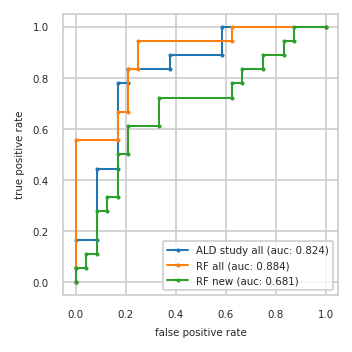

In [21]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.test, results_ald_full.name, ax)
plot_split_auc(results_model_full.test, results_model_full.name, ax)
plot_split_auc(results_model_new.test, results_model_new.name, ax)
fname = args.out_folder / 'auc_roc_curve.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Data used to plot ROC:

In [22]:
res = [results_ald_full, results_model_full, results_model_new]

auc_roc_curve = parse_roc(*res)
auc_roc_curve.to_excel(fname.with_suffix('.xlsx'))
auc_roc_curve

ALD study all       RF all       RF new      
             fpr   tpr    fpr   tpr    fpr   tpr
0          0.000 0.000  0.000 0.000  0.000 0.000
1          0.000 0.056  0.000 0.056  0.000 0.056
2          0.000 0.167  0.000 0.556  0.042 0.056
3          0.083 0.167  0.167 0.556  0.042 0.111
4          0.083 0.444  0.167 0.667  0.083 0.111
5          0.167 0.444  0.208 0.667  0.083 0.278
6          0.167 0.778  0.208 0.833  0.125 0.278
7          0.208 0.778  0.250 0.833  0.125 0.333
8          0.208 0.833  0.250 0.944  0.167 0.333
9          0.375 0.833  0.625 0.944  0.167 0.500
10         0.375 0.889  0.625 1.000  0.208 0.500
11         0.583 0.889  1.000 1.000  0.208 0.611
12         0.583 1.000    NaN   NaN  0.333 0.611
13         1.000 1.000    NaN   NaN  0.333 0.722
14           NaN   NaN    NaN   NaN  0.625 0.722
15           NaN   NaN    NaN   NaN  0.625 0.778
16           NaN   NaN    NaN   NaN  0.667 0.778
17           NaN   NaN    NaN   NaN  0.667 0.833
18           NaN   NaN    NaN   NaN  0.750 0.833
19           NaN   NaN    NaN   NaN  0.750 0.889
20           NaN   NaN    NaN   NaN  0.833 0.889
21           NaN   NaN    NaN   NaN  0.833 0.944
22           NaN   NaN    NaN   NaN  0.875 0.944
23           NaN   NaN    NaN   NaN  0.875 1.000
24           NaN   NaN    NaN   NaN  1.000 1.000

### Features selected for final models

In [23]:
selected_features = pd.DataFrame(
    [results_ald_full.selected_features,
     results_model_full.selected_features,
     results_model_new.selected_features],
    index=[
        results_ald_full.name,
        results_model_full.name,
        results_model_new.name]
).T
selected_features.index.name = 'rank'
fname = args.out_folder / 'mrmr_feat_by_model.xlsx'
files_out[fname.name] = fname
selected_features.to_excel(fname)
selected_features

,ALD study all,RF all,RF new
rank,,,
0,P10636-2;P10636-6,Q9Y2T3;Q9Y2T3-3,Q14894
1,Q15848,P09960;P09960-4,A0A087WTT8;A0A0A0MQX5;O94779;O94779-2
2,P01597;P04432,P10643,P31150
3,P61981,P10636-2;P10636-6,A0A075B7B8
4,P04075,P14174,Q96GD0
5,P14174,P04075,P31321
6,P00338;P00338-3,P61981,J3KSJ8;Q9UD71;Q9UD71-2
7,Q9Y2T3;Q9Y2T3-3,P15151-2,O95497
8,P25189;P25189-2,Q14894,A0A0J9YW36;Q9NZ72;Q9NZ72-2


### Precision-Recall plot on test data

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/prec_recall_curve.pdf


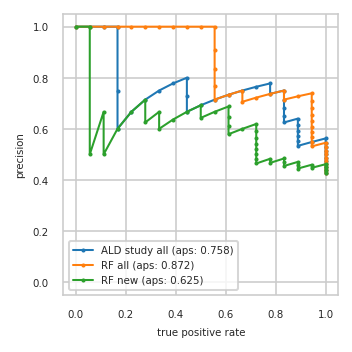

In [24]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.test, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.test, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.test, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Data used to plot PRC:

In [25]:
prec_recall_curve = parse_prc(*res)
prec_recall_curve.to_excel(fname.with_suffix('.xlsx'))
prec_recall_curve

ALD study all          RF all          RF new      
       precision   tpr precision   tpr precision   tpr
0          0.429 1.000     0.429 1.000     0.429 1.000
1          0.439 1.000     0.439 1.000     0.439 1.000
2          0.450 1.000     0.450 1.000     0.450 1.000
3          0.462 1.000     0.462 1.000     0.462 1.000
4          0.474 1.000     0.474 1.000     0.447 0.944
5          0.486 1.000     0.486 1.000     0.459 0.944
6          0.500 1.000     0.500 1.000     0.444 0.889
7          0.514 1.000     0.514 1.000     0.457 0.889
8          0.529 1.000     0.529 1.000     0.471 0.889
9          0.545 1.000     0.545 1.000     0.455 0.833
10         0.562 1.000     0.531 0.944     0.469 0.833
11         0.548 0.944     0.548 0.944     0.484 0.833
12         0.533 0.889     0.567 0.944     0.467 0.778
13         0.552 0.889     0.586 0.944     0.483 0.778
14         0.571 0.889     0.607 0.944     0.464 0.722
15         0.593 0.889     0.630 0.944     0.481 0.722
16         0.615 0.889     0.654 0.944     0.500 0.722
17         0.640 0.889     0.680 0.944     0.520 0.722
18         0.625 0.833     0.708 0.944     0.542 0.722
19         0.652 0.833     0.739 0.944     0.565 0.722
20         0.682 0.833     0.727 0.889     0.591 0.722
21         0.714 0.833     0.714 0.833     0.619 0.722
22         0.750 0.833     0.750 0.833     0.600 0.667
23         0.737 0.778     0.737 0.778     0.579 0.611
24         0.778 0.778     0.722 0.722     0.611 0.611
25         0.765 0.722     0.706 0.667     0.647 0.611
26         0.750 0.667     0.750 0.667     0.688 0.611
27         0.733 0.611     0.733 0.611     0.667 0.556
28         0.714 0.556     0.714 0.556     0.643 0.500
29         0.692 0.500     0.769 0.556     0.692 0.500
30         0.667 0.444     0.833 0.556     0.667 0.444
31         0.727 0.444     0.909 0.556     0.636 0.389
32         0.800 0.444     1.000 0.556     0.600 0.333
33         0.778 0.389     1.000 0.500     0.667 0.333
34         0.750 0.333     1.000 0.444     0.625 0.278
35         0.714 0.278     1.000 0.389     0.714 0.278
36         0.667 0.222     1.000 0.333     0.667 0.222
37         0.600 0.167     1.000 0.278     0.600 0.167
38         0.750 0.167     1.000 0.222     0.500 0.111
39         1.000 0.167     1.000 0.167     0.667 0.111
40         1.000 0.111     1.000 0.111     0.500 0.056
41         1.000 0.056     1.000 0.056     1.000 0.056
42         1.000 0.000     1.000 0.000     1.000 0.000

## Train data plots

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/prec_recall_curve_train.pdf


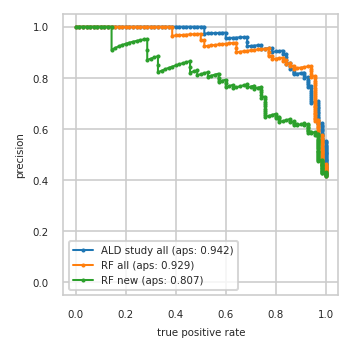

In [26]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.train, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.train, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve_train.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/auc_roc_curve_train.pdf


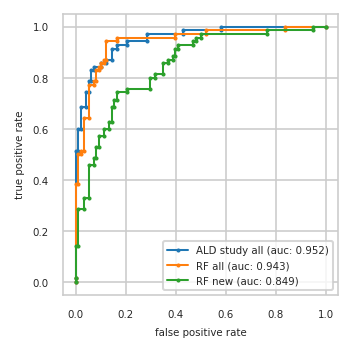

In [27]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.train, results_ald_full.name, ax)
plot_split_auc(results_model_full.train, results_model_full.name, ax)
plot_split_auc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'auc_roc_curve_train.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Output files:

In [28]:
files_out

{'results_RF all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/results_RF all.pkl'),
 'results_RF new.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/results_RF new.pkl'),
 'results_ALD study all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/results_ALD study all.pkl'),
 'auc_roc_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/auc_roc_curve.pdf'),
 'mrmr_feat_by_model.xlsx': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/mrmr_feat_by_model.xlsx'),
 'prec_recall_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/prec_recall_curve.pdf'),
 'prec_recall_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/prec_recall_curve_train.pdf'),
 'auc_roc_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/auc_roc_curve_train.pdf')}